<a href="https://colab.research.google.com/github/ChrisKal-el/Classifier-Comparison/blob/main/Classifier_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** Classifier Performance Comparison **

---

## Introduction

There are multiple types of classifier models used in image classification; oftentimes, comparisons will be done on different datasets with different metrics used to evaluate the models' performance.

One method used here is to compare the attention mechanisms used in two different models.  Attention allows for neural networks to focus on specific characteristics in an image that is considered significant for its classification.
Self-attention in each segment of an image identifies the inter-relationships between them, calculating values that shift layer to layer.
The final layer is often best representative of the focus of the model when used in classifying an image.
In the two models below, that is represented in form of an RGB heat map.

The two model types compared here are Vision Transformers and Residual Networks.
Vision Transformers breaks the trend of recurrent neural networks and relies on attention to describe global relationships between input and output instead of recurrence.
Residual Networks use residual functions with reference to the layer inputs to create a residual mapping.
The residual value for layers with less relevance to the residual mapping will be near zero and will be skipped.  

In [13]:
!pip install timm

In [16]:

!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/cutegoat.jpg?raw=true -O /content/cutegoat.jpg
!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/catpic.jpg?raw=true -O /content/catpic.jpg
!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/guppynotreally.jpg?raw=true -O /content/guppynotreally.jpg
!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/womentour.jpg?raw=true -O /content/womentour.jpg
!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/titanic.jpg?raw=true -O /content/titanic.jpg
!wget https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/alien.jpg?raw=true -O /content/alien.jpg
input_file = '/content/cutegoat.jpg'
input_file2 = '/content/catpic.jpg'
input_file3 = '/content/guppynotreally.jpg'
input_file4 = '/content/womentour.jpg'
input_file5 = '/content/titanic.jpg'
input_file6 = '/content/alien.jpg'

--2025-05-21 00:29:42--  https://github.com/ChrisKal-el/Classifier-Comparison/blob/main/images/raw/cutegoat.jpg?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ChrisKal-el/Classifier-Comparison/raw/refs/heads/main/images/raw/cutegoat.jpg [following]
--2025-05-21 00:29:42--  https://github.com/ChrisKal-el/Classifier-Comparison/raw/refs/heads/main/images/raw/cutegoat.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ChrisKal-el/Classifier-Comparison/refs/heads/main/images/raw/cutegoat.jpg [following]
--2025-05-21 00:29:43--  https://raw.githubusercontent.com/ChrisKal-el/Classifier-Comparison/refs/heads/main/images/raw/cutegoat.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199

## Vision Transformer
---

In a vision transformer, the image is resized into a square image for simplicity and uniformity in processing.
For the default model that is loaded, the image is resized into 224x224 pixesl.
Then, the image is broken down further into a series of square patches which are positional embeddings corresponding to a segment of the image.
The number of patches is dependent on the model set up; for the case of the imported model, this is a set of 16x16 patches.

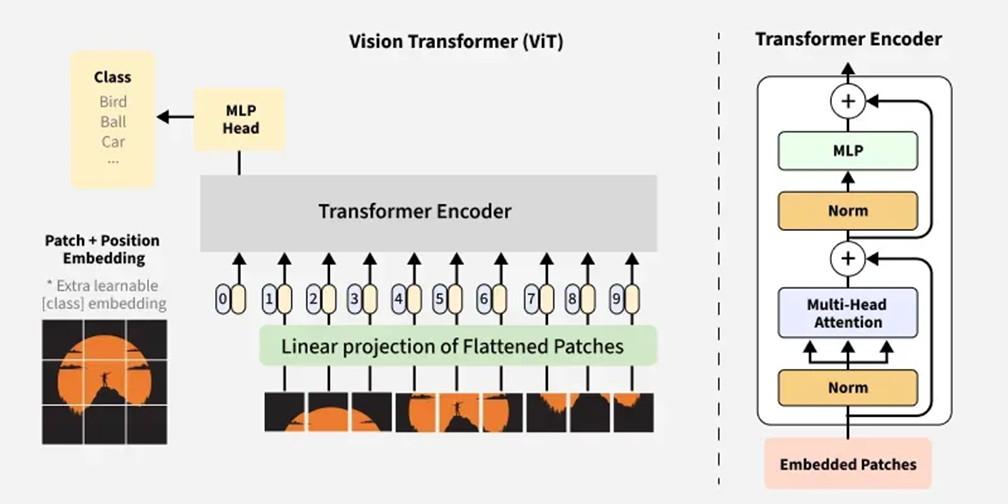

The patches pass forward through the transformer encoder layers.
One such layer is the multi-head self attention mechanism which calculates the relationship between different patches, computing an attention score for each patch based on its similarity to other patches.
This attention score allows the model to focus on different parts of the image which are more significant.
More information can be found in the original paper https://arxiv.org/pdf/1706.03762v7

$$Attention(Q,K,V) = softmax(\frac{Q_{K}^{T}}{\sqrt{d_{k}}})V$$

The feed-forward network passes the patches through normalization and residual layers reducing outliers after attention mechanism calculations and improving convergence later on through the model.
Through the model, a CLS token is generated and updated based on the attention mechanism values and their position with respect to other patches.
This token is used in image classifications according to classes present.

The model below uses a pretrained model that can be adjusted in the create_model input.

In [14]:
import numpy as np
import cv2
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from IPython.display import display

##Functions for Attention Maps

# Visualize total layers attention maps
def visualize_attention(attn_maps_np):
    num_layers = len(attn_maps_np)
    num_heads = attn_maps_np[0].shape[0]

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 2, num_layers * 2))

    for i in range(num_layers):
        for j in range(num_heads):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            attn_map = attn_maps_np[i][j]  # shape: [num_tokens, num_tokens]
            ax.imshow(attn_map, cmap='viridis')
            ax.set_title(f"L{i+1}H{j+1}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize last layer of attention maps
def show_attention_overlay(image_tensor, attn_map, patch_size=16, alpha=0.6):
    """
    Overlay attention map on top of the input image.
    """
    image = to_pil_image(image_tensor.squeeze(0).cpu()).convert("RGB")
    image_np = np.array(image)

    # Use only the class token's attention to other tokens (shape: [num_tokens])
    # In ViT, first token (index 0) is class token, so take its attention
    cls_attn = attn_map[:, 0, 1:]  # Exclude the class token itself

    # Assume square grid of patches
    num_patches = cls_attn.shape[-1]
    grid_size = int(np.sqrt(num_patches))
    cls_attn_map = cls_attn.reshape(grid_size, grid_size)

    # Normalize attention map
    cls_attn_map -= cls_attn_map.min()
    cls_attn_map /= cls_attn_map.max()

    # Resize attention map to image resolution
    cls_attn_map_resized = cv2.resize(cls_attn_map, (image_np.shape[1], image_np.shape[0]))
    cls_attn_map_color = cv2.applyColorMap(np.uint8(255 * cls_attn_map_resized), cv2.COLORMAP_JET)
    cls_attn_map_color = cv2.cvtColor(cls_attn_map_color, cv2.COLOR_BGR2RGB)

    # Overlay attention on original image
    overlay = (1 - alpha) * image_np + alpha * cls_attn_map_color
    overlay = overlay.astype(np.uint8)

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Class Token Attention Overlay")
    plt.show()


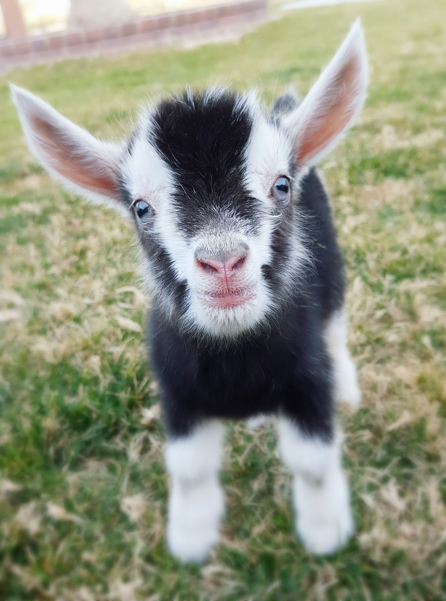

cliff 0.02293781191110611
chimpanzee 0.022402601316571236
sloth bear 0.01619061827659607


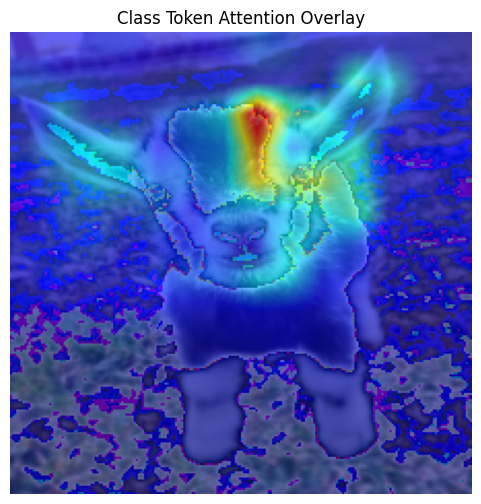

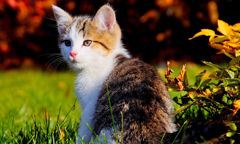

chimpanzee 0.027356449514627457
cliff 0.019969439134001732
orangutan 0.017653025686740875


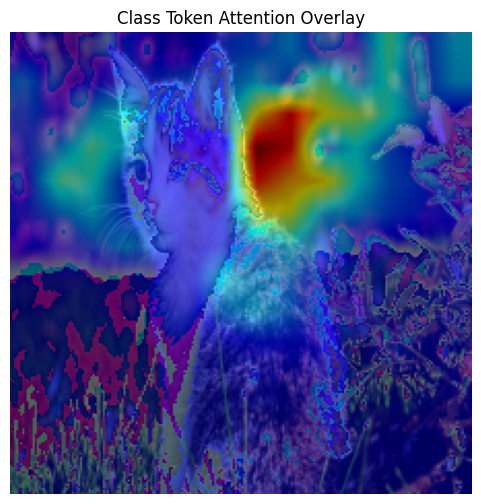

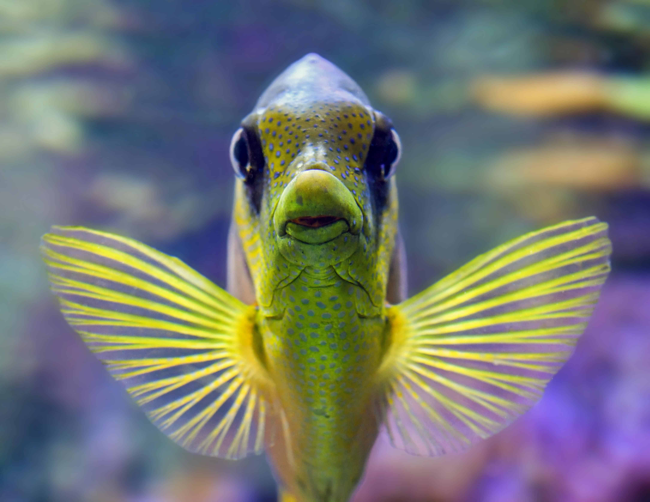

cliff 0.023006882518529892
chimpanzee 0.022178824990987778
sloth bear 0.019894598051905632


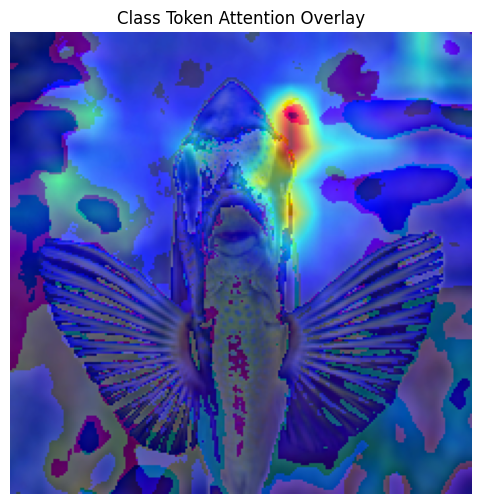

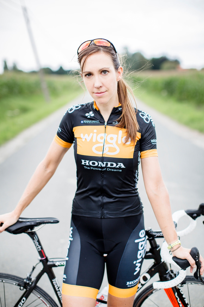

cliff 0.021249201148748398
chimpanzee 0.018246715888381004
lesser panda 0.017462387681007385


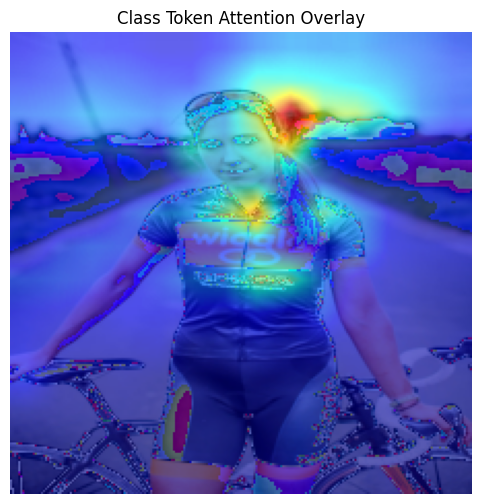

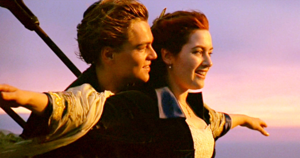

disk brake 0.019085576757788658
chimpanzee 0.018275585025548935
cliff 0.015901658684015274


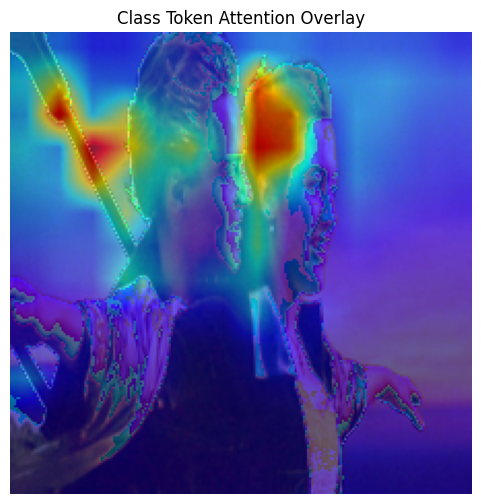

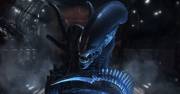

chimpanzee 0.028639933094382286
cliff 0.02001982554793358
sloth bear 0.0181854497641325


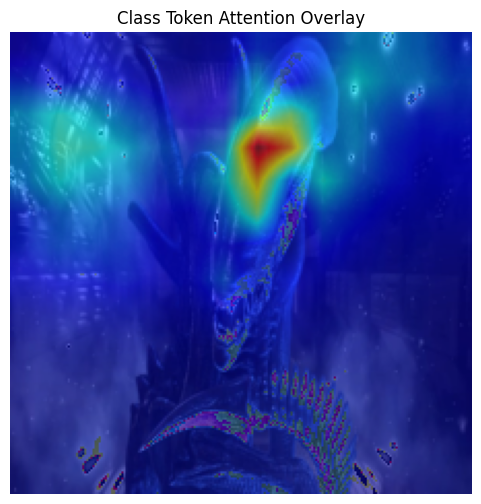

In [17]:
#Vision Transformer
import torch
import torch.nn as nn
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import urllib
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import requests
from transformers import ViTImageProcessor, ViTForImageClassification
import requests

#Vision Transformer 1
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

#Vision Transformer 2 - secondary model for testing - uncomment if interested in testing
#processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
#model1 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Safely override the forward function of transformer blocks
# Define how attention scores will be extracted
for blk in model.blocks:
    # Provide default drop_path if it doesn't exist
    if not hasattr(blk, 'drop_path'):
        blk.drop_path = nn.Identity()

    def new_forward(self, x):
        B, N, C = x.shape

        qkv = self.attn.qkv(x).reshape(B, N, 3, self.attn.num_heads, C // self.attn.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) * self.attn.scale
        attn_weights = attn_scores.softmax(dim=-1)  # (B, num_heads, N, N)
        self.attn_weights = attn_weights  # Store for external use

        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        attn_output = self.attn.proj(attn_output)

        x = x + self.drop_path(attn_output)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return self.norm1(x)

    # Inject our forward method into each block
    blk.forward = new_forward.__get__(blk, type(blk))

# Define function for processing images through ViT
def ImageProcess(input_file):
  image = Image.open(input_file).convert("RGB")
  transform = T.Compose([
      T.Resize((224, 224)),
      T.ToTensor(),
      T.Normalize((0.5,), (0.5,))
  ])
  input_tensor = transform(image).unsqueeze(0)

  attention_maps = []

  # Forward pass
  with torch.no_grad():
      out = model(input_tensor)
      #model1(input_tensor)

  # Extract stored attention maps
  attn_maps_np = [blk.attn_weights.squeeze(0).cpu().numpy() for blk in model.blocks]

  #Display original resized image
  display(image.resize(( int(image.width * 0.15), int(image.height * 0.15))))

  #Apply this to the final layer attention map
  last_layer_attn = attn_maps_np[-1]  # [num_heads, num_tokens, num_tokens]
  #This is the portion where the attention is averaged in the last layer before applying to an image
  avg_attn = np.mean(last_layer_attn, axis=0, keepdims=True)  # [1, num_tokens, num_tokens]

  # ViT1 model predicts one of the 1000 ImageNet classes
  probabilities = torch.nn.functional.softmax(out[0], dim=0)
  # get imagenet class mappings
  url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
  urllib.request.urlretrieve(url, filename)
  with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
  top3_prob, top3_catid = torch.topk(probabilities, 3) #can change the number for number of predictions
  for i in range(top3_prob.size(0)):
    print(categories[top3_catid[i]], top3_prob[i].item())

  ##Vision Transformer 2 model predictions
  #inputs = processor(images=image, return_tensors="pt")
  #outputs = model1(**inputs)
  #logits = outputs.logits
  #predicted_class_idx = logits.argmax(-1).item()
  #print("Predicted class:", model1.config.id2label[predicted_class_idx])

  #Uncomment if you want to see total attention maps for each layer
  #visualize_attention(attn_maps_np)

  # Show attention overlay
  show_attention_overlay(input_tensor, avg_attn)

ImageProcess(input_file)
ImageProcess(input_file2)
ImageProcess(input_file3)
ImageProcess(input_file4)
ImageProcess(input_file5)
ImageProcess(input_file6)

In [19]:
!pip install grad-cam
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=da37056fac6a6d4e3d04ea26d2c282def7d8e9d997926c2baf01f1eaa4b419a6
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


## Residual Networks

---

Residual networks are a type of convolutional neural network that utilizes residual layers to reduce the effect of vanishing gradient as the number of layers increases.
The following paper "Deep Residual Learning for Image Recognition" goes into more depth regarding the structure of DNN using residual learning.
https://arxiv.org/abs/1512.03385

The first few layers begin with input pre-processing where the image is resized and normalized.
The processed image is converted into multiple dimensional layers utilizing a max pooling layer with a ReLu activation function.
There are several blocks of these convolutional layers, for the ResNet50 model used below, there are 4 blocks of convlutional layers.
The block contains skip connections/residual connections that bypass several layers from one activation to the next.
This allows the gradients to retain information instead of shrinking as the number of layers increases.
After the convolutional blocks, the array is flattened back to a two-dimensional array in a fully-connected layer.
The output of the final fully-connected layer is used in a softmax activation function for producing the class probabilities.

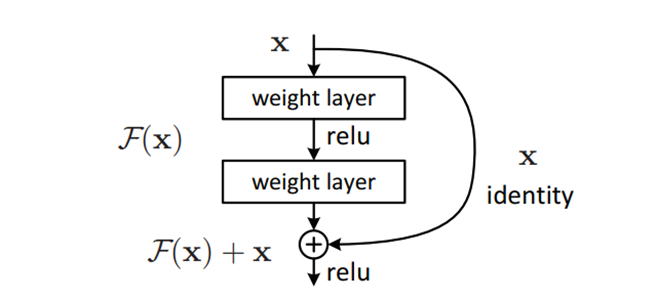

The torchvision ResNet50 model used in the example below was pretrained on the ImageNet database.  The classifier also utilizes the 1000 category classification set.
This can be substituted with the ResNet50 models from the keras and timm modules and tested.
Further information can be found at their respective github pages.
https://github.com/pprp/timm/blob/master/docs/models/resnet.md
https://github.com/pytorch/vision/blob/main/docs/source/models/resnet.rst

Rather than visualizing an attention map, GradCAM is used to visualize the class activation map of the final convolutional layer that functions similarly to the visualization of the attention map in the visual transformer.
The activation map uses a heatmap concept to emphasize the segments of the image that are significant in predicting the class.
More information on Grad-CAM can be found at https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/CAM%20Metrics%20And%20Tuning%20Tutorial.ipynb


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


bucket 0.006218345370143652


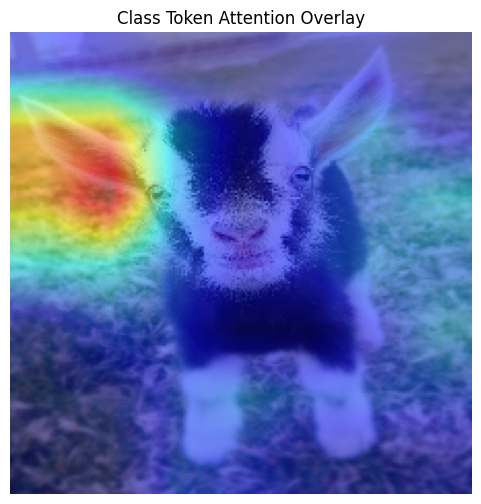

tiger cat 0.47768574953079224


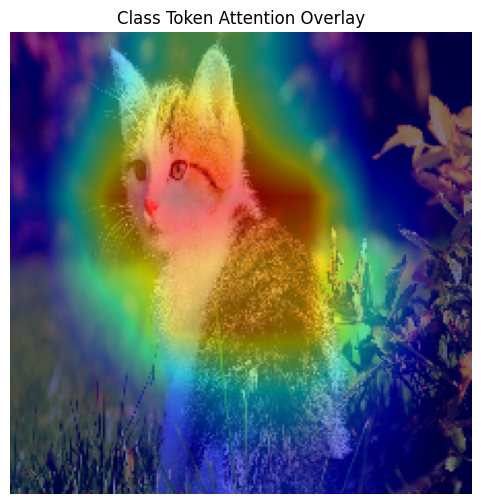

puffer 0.39021021127700806


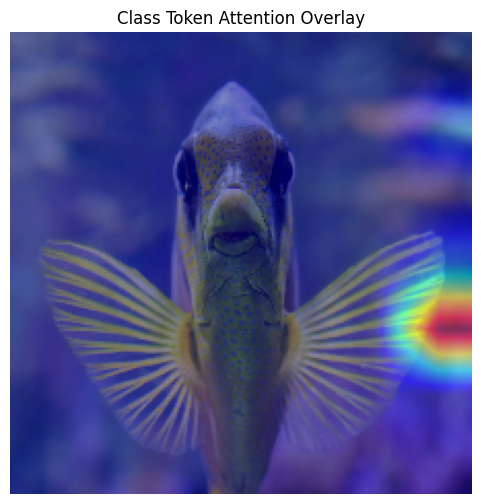

mountain bike 0.5096758008003235


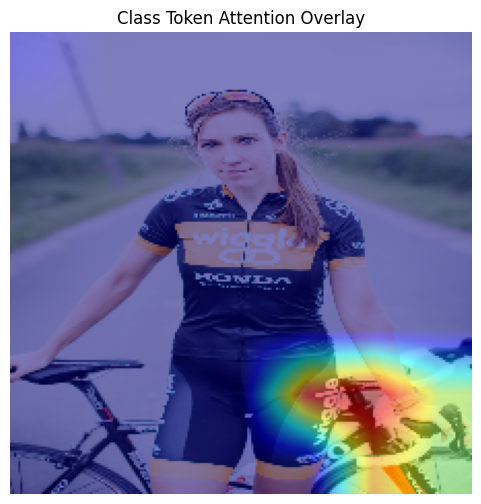

drumstick 0.22184962034225464


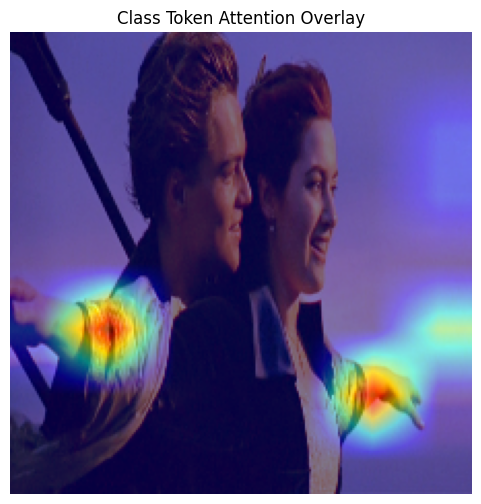

ashcan 0.09732137620449066


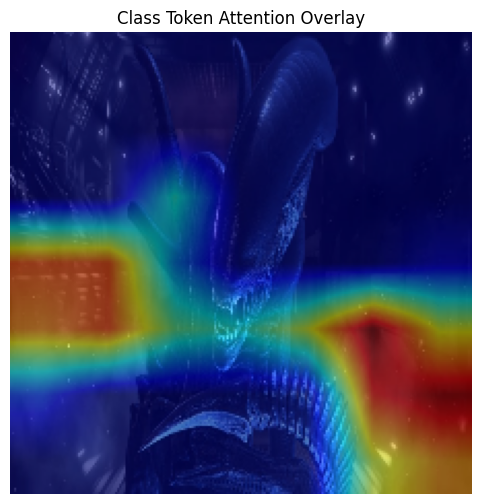

In [20]:
##ResNet Model

import torch
import torch.nn as nn
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50, decode_predictions

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model2 = resnet50(pretrained=True)
target_layers = [model2.layer4[-1]]

def ImageProcess2(input_file):
  #Create attention maps
  attention_maps = []

  #Specify target to generate CAM for
  targets = [ClassifierOutputTarget(281)]

  # Load and preprocess image
  image = Image.open(input_file).convert("RGB")
  rgb_img = cv2.imread(input_file, 1)[:, :, ::-1]
  rgb_img = np.float32(rgb_img) / 255
  rgb_img = cv2.resize(rgb_img, (224, 224))

  transform = T.Compose([
      T.Resize((224, 224)),
      T.ToTensor(),
      T.Normalize((0.5,), (0.5,))
  ])
  input_tensor = transform(image).unsqueeze(0)

  # Predict the subject of the image
  with torch.no_grad():
      out = model2(input_tensor)
  probabilities = torch.nn.functional.softmax(out[0], dim=0)
  url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
  urllib.request.urlretrieve(url, filename)
  with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

  # Print top categories per image
  top_prob, top_catid = torch.topk(probabilities, 1)
  for i in range(top_prob.size(0)):
    print(categories[top_catid[i]], top_prob[i].item())

  #Model Fwd Pass
  with GradCAM(model2, target_layers) as cam:
    grayscale_cam = cam(input_tensor, targets)
    grayscale_cam = grayscale_cam[0, :]
    #grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    model_outputs = cam.outputs

  # plot last layer of attention map
  plt.figure(figsize=(6, 6))
  plt.imshow(visualization)
  plt.axis("off")
  plt.title("Class Token Attention Overlay")
  plt.show()

#These can be replace by individual images or an array of images instead
ImageProcess2(input_file)
ImageProcess2(input_file2)
ImageProcess2(input_file3)
ImageProcess2(input_file4)
ImageProcess2(input_file5)
ImageProcess2(input_file6)